<img src="logo.png">
<h2><center>MScFE 630 Computational Finance<br><br>Group Work Project<br><br>August 19, 2019<br><br><small><i>Gustavo Campos - gustavoc82@me.com<br>Hoang Dinh - hoangdinh.2710@gmail.com<br>Bosco Keown - bosco.keown@gmail.com</i></small></center></h2>
<h2><center>Abstract</center></h2>
In this article, we price a European up-and-out call option held with a risky counterparty. First, we describe the pricing in mathematical terms then we simulate entire share price paths to estimate the price of this option, assuming that both the stock and counterparty firm values follow a Geometric Brownian Motion with a non-constant interest rate and local volatility, and that default only occurs at maturity. Additionally, we use a set of pre-established parameters and sample size. We simulate interest rates using a LIBOR forward rate model. Subsequently, we implement local volatility functions in order to simulate the share and firm's prices, determine Monte Carlo estimates of both the default-free value of the option and the Credit Valuation Adjustment (CVA) and calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA. 

<b><i>Keywords:</i></b> European up-and-out call option, Monte Carlo, Calibration, Credit Valuation Adjustment.

# Introduction

The first popular model of the dynamics of the interest rate is the Vasicek model proposed in 1977. Vasicek's model describes the movement of an interest rate as a factor composed of market risk, time, and equilibrium value, where the rate tends to revert towards the mean of those factors over time. 

Exotic options are a category of options contracts that differ from traditional options in their payment structures, expiration dates, and strike prices. The underlying asset or security can vary with exotic options allowing for more investment alternatives. Exotic options can be customized to meet the risk tolerance and desired profit of the investor. Although exotic options provide flexibility, they do not guarantee profits.

Barrier options are probably the oldest of all exotic options. Barrier options were first introduced in 1967, and they are similar to plain vanilla calls and puts, but only become activated or extinguished when the underlying asset hits a preset price level. The barriers are referred to as “In” or “Out”. “In” options are paid for upfront and only come into existence if the asset price hits the barrier before expiration. “Out” options are similar except the options become worthless if the asset price hits the barrier before expiration.

In this paper, we price a European up-and-out call option, and consider the credit value adjustment (CVA) of the option's price, given a counterparty firm value, correlation and local volatility dynamics.

# Barrier Options

Barrier options are path-dependent exotic options that are similar to vanilla European options in many regards except for the fact that there is a "barrier" at which the option either comes into existence or ceases to exist. This is unique because, in order to analyze the option, we only need to know whether or not the barrier has been exceeded during the life of the option.

There are two types of barrier options; knock-in options and knock-out options. Each of these has a call/put variation which leads to four different option types usually called down-and-out, down-and-in, up-and-out, and up-and-in. Knock-in options are an option that comes into existence only when the barrier is reached. On the other hand, knock-out options cease to exist if and when the barrier is reached.

Barrier options are attractive to some investors because the premium is typically lower due to the additional constraints and contingencies compared to vanilla options. For example, an investor who wishes to hedge a position may choose to use a barrier option over a vanilla option if they only want their hedge to take effect at a certain price (knock-in). A practical example would be an oil producer who knows that if oil drops below \\$40 per barrel, they will become unprofitable. They could purchase a down-and-in option at that strike price in order to hedge their business if the commodity reaches that barrier. Conversely, a trader who is confident that a certain threshold will not be reached could choose to purchase a knock-out option since it will be cheaper, and they do not anticipate the price exceeding the barrier anyway.

There are many ways to price barrier options including models like the Binomial Tree, Monte Carlo, and numerical methods. Of course, the Black-Scholes framework is also helpful for pricing barrier options, although this method has been criticized as being more error-prone because of its more restrictive assumptions. In particular, barrier options seem to be sensitive to misspecification in the model. Regardless, closed-form solutions for pricing these options have been developed.

## Repricing a European up-and-out Call Option

In order to price a European up-and-out option at maturity $T$, We know that its equation can be represented by:

$$v(S_t)=(S_t-K)^+ \quad \text{given } \max\limits_{t \in [0,T]} S_t < B$$

where $K$ is the strike of the option, $B$ is the barrier level, and $S_t$ is the share price at time $t$.

We assume that both the stock and counterparty firm values follow Geometric Brownian Motion with a non-constant interest rate and local volatility, and default only occurs at maturity. Also, we use the following parameters:

- The maturity of the option is in a year's time
- The option is struck at-the-money
- The up-and-out barrier for the option is \$150
- The current share price is \$100
- The current firm value for the counterparty is \$200
- The counterparty's debt, due in one year, is \$175
- The correlation between the counterparty and the stock is constant at 0.2
- The recovery rate with the counterparty is 25%

With this predefined set of parameters, we import the necessary libraries and create the necessary classes in order to reprice a European up-and-out Call Option.

In [2]:
################################################
# European (up-and-out) Option Pricer 
################################################

# import libraries
import pandas as pd
import numpy as np
import scipy.optimize
from scipy.stats import uniform, norm
from matplotlib import pyplot as plt
from matplotlib import style
from scipy import log,exp,sqrt,stats 
from random import gauss

%matplotlib inline
np.random.seed(0)

#-----------------------------------------------
# European up-and-out option class 
#-----------------------------------------------
    
class Option():
    """parameters"""
    def __init__(self, S = 100.0, Sf = 200.0, v = 0.3, r = 0.08, vf = 0.3, T = 1.0, 
                 K = 100.0, B = 150.0, N = 12, D = 175.0, c = 0.2, rr = 0.25):
        """constructor"""
        """Stock parameters"""
        self.S = S                     # initial asset price
        self.v = v                     # initial volatility 
        self.r = r                     # 10 year risk free rate
        self.T = T                     # years until maturity
        self.K = K                     # strike price
        self.B = B                     # barrier price
        self.N = N                     # number of discrete time points
        self.delta_t = self.T / self.N # timestep 
        
        """parameters of counterparty firm"""
        self.Sf = Sf                   # initial asset price
        self.vf = vf                   # initial volatility
        self.D = D                     # debt
        self.rr = rr                   # recovery rate
        self.c = c                     # correlation
        
    def __str__(self):
        """print parameters"""
        return "---------------------------------------------\n" \
            + "Parameters of European Option:\n" \
            + "---------------------------------------------\n" \
            + "Initial Asset Price = " + str(self.S) + "\n" \
            + "Initial Volatility = " + str(self.v) + "\n" \
            + "Risk-Free 10 Year Treasury Rate = " + str(self.r) + "\n" \
            + "Years Until Expiration = " + str(self.T) + "\n" \
            + "Strike Price = " + str(self.K) + "\n" \
            + "Barrier Price = " + str(self.B) + "\n" \
            + "Discrete time points = " + str(self.N) + "\n" \
            + "Initial Counterparty Firm Price = " + str(self.Sf) + "\n" \
            + "Initial Counterparty Firm Volatility = " + str(self.vf) + "\n" \
            + "Counterparty Firm Debt = " + str(self.D) + "\n" \
            + "Recovery Rate = " + str(self.rr) + "\n" \
            + "Correlation = " + str(self.c) + "\n" \
            + "---------------------------------------------"
    
    def analytic_price(self):
        d1=(log(self.S/self.K)+(self.r+self.v**2/2.)*T)/(self.v*sqrt(self.T)) 
        d2 = d1-self.v*sqrt(self.T)
        self.analytic_price = self.S*stats.norm.cdf(d1)-self.K*exp(-self.r*self.T)*stats.norm.cdf(d2) 
        return self.analytic_price

#-----------------------------------------------
# main program
#-----------------------------------------------
# option parameters
S = 100.0                              # Initial asset price
v = 0.3                                # initial volatility
r = 0.08                               # 10 year risk free rate
T = 1.0                                # years until maturity
K = 100.0                              # strike price
B = 150.0                              # barrier price
N = 12                                 # Number of discrete time points ("monthly simulations")

# counterparty firm parameters
Sf = 200                               # initial asset price
vf = 0.3                               # initial volatility
D = 175.0                              # debt
c = 0.2                                # correlation
rr = 0.25                              # recovery rate

# creating European up-and-out option object
opt = Option(S, Sf, v, r, vf, T, K, B, N, D, c, rr)
print(opt)
print("Analytic Price = ",opt.analytic_price())

---------------------------------------------
Parameters of European Option:
---------------------------------------------
Initial Asset Price = 100.0
Initial Volatility = 0.3
Risk-Free 10 Year Treasury Rate = 0.08
Years Until Expiration = 1.0
Strike Price = 100.0
Barrier Price = 150.0
Discrete time points = 12
Initial Counterparty Firm Price = 200
Initial Counterparty Firm Volatility = 0.3
Counterparty Firm Debt = 175.0
Recovery Rate = 0.25
Correlation = 0.2
---------------------------------------------
Analytic Price =  15.711312547892973


The local volatility functions for both the stock and the counterparty have the same form as in submission 2 - part 2, namely $\sigma (t_i,t_{i+1}) = \sigma(S_{t_i})^{\gamma-1}$. For the stock $\sigma_S (t_i,t_{i+1}) = 0.3(S_{t_i})^{\gamma-1}$, and for the counterparty, $\sigma_V (t_i,t_{i+1}) = 0.3(V_{t_i})^{\gamma-1}$, where γ = 0.75.

We can simulate the next step in a share price path using the following formula:

$$S_{t_{i+1}} = S_{t_i} e^{\left( r - \frac{\sigma^2 \left( t_i, t_{i+1} \right)}{2} \right) \, (t_{i+1}-t_i) \, + \, \sigma(t_i,t_{i+1}) \, \sqrt{t_{i+1} - t_i} \, Z}$$

where $S_{t_i}$ is the share price at time $t_i, \sigma(t_i,t_{i+1})$ is the volatility for the period $[t_i,t_{i+1}], r_{t_i}$ is the risk-free interest rate, and $Z \sim N(0,1)$. The counterparty firm values can be simulated similarly.

You observe the following zero-coupon bond prices (per \\$100 nominal) in the market:

|Maturity|Price|Maturity|Price|
|:------:|:-------:|:------:|:-------:|
|1 month | \\$99.38|7 months| \\$95.74|
|2 months| \\$98.76|8 months| \\$95.16|
|3 months| \\$98.15|9 months| \\$94.57|
|4 months| \\$97.54|10 months| \\$93.99|
|5 months| \\$96.94|11 months| \\$93.42|
|6 months| \\$96.34|12 months| \\$92.85|

You are required to use a LIBOR forward rate model to simulate interest rates. The initial values for the LIBOR forward rates need to be calibrated to the market forward rates which can be deduced through the market zero-coupon bond prices given above. This continuously compounded interest rate for $[t_i,t_{i+1}]$ at time $t_i$, is then given by the solution to:

$$e^{r_{ti}(t_{i+1}-t_i)} = 1 + \text{L}(t_i,t_{i+1})(t_{i+1}-t_i),$$

Where $\text{L}(t_i,t_{i+1})$ is the LIBOR forward rate which applies from $t_i$ to $t_{i+1}$, at time $t_i$. Note that these LIBOR rates are updated as you run through the simulation, and so your continuously
compounded rates should be as well.

### LIBOR model

We used the actual bond prices to calibrate the parameters $r_0, \alpha , \beta , \sigma$ for the Vasicek Model. We then use the parameters previously found to construct the bond prices for the same sets of maturities. The simulated bond prices are very close to the actual prices. Once we construct the bond prices, we are able to calculate the forward rates and the interest rates for each step in the price path.

The forward rates are simulated using the LIBOR model:

$$\hat F_j(t_i) = \hat F_j(t_{i-1}) * e^{(\hat \mu_j(t_{i-1}) - \frac{1}{2}*\sigma^2)*\gamma_(i-1) + \sigma_j*\sqrt{\gamma_{i-1} }  \mathbb{Z_i} }$$

Where $\hat F_j(t_i)$ is the approximation for the $j^{th}$ forward rate at time $t_i, \mathbb {Z_i} ~ \mathbb{N(0,1)}$. The interest rates are calculated from the forward rates above:

$$e^{r_{t_i} ( t_{i+1} - t_i )} = 1 + F_{t_i, t_{i+1}} (t_{t+1} - t_i)  $$

Where $F_{t_i, t_{i+1}}$ is the LIBOR forward rate which applies from $t_i$ to $t_{i+1}$.

In [3]:
"""Analytical bond price Close form solution using Vasicek model"""
def A(t1,t2,alpha):
    return (1-np.exp(-alpha*(t2-t1))) / alpha

def D(t1,t2,alpha,b,sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1 - val2

def bond_price(r,t,T,alpha,b,sigma):
    return np.exp(-A(t,T,alpha)*r +D(t,T,alpha,b,sigma))

# actual zero-coupon bond prices & maturities
zcb_prices = np.array([100,99.38, 
              98.76,98.15,97.54,
              96.9496.34,95.74,
              95.16,94.57,93.99,
              93.42,92.85])/100.

maturity = np.array([opt.delta_t * n for n in range(opt.N+1)])
# difference between the Vasicek Bond Price and the actual Bond Prices
def F(x):
    r0 = x[0]
    alpha = x[1]
    b = x[2]
    sigma = x[3]
    return np.sum(np.abs(bond_price(r0,0,maturity,alpha,b,sigma) - zcb_prices))

# define the boundary for parameters
bounds = ((0,0.2),(0,5),(0,0.5),(0,2))
# use the minize function in the Scipy package to calibrate parameters
opt_val = scipy.optimize.fmin_slsqp(F,(0.05,0.3,0.05,0.03),bounds=bounds)
opt.r = opt_val[0]
opt.alpha = opt_val[1]
opt.beta = opt_val[2]
opt.sigma = opt_val[3]

# print the results
print('\nCalibrated values:')
print('Interest rate = {}'.format(opt.r))
print('Alpha = {}'.format(opt.alpha))
print('Beta = {}'.format(opt.beta))
print('Volatility = {}'.format(opt.sigma))

# estimation model bond prices
opt.model_prices = bond_price(opt.r,0,maturity,opt.alpha,opt.beta,opt.sigma)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00024383601983268832
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11

Calibrated values:
Interest rate = 0.07490754544726819
Alpha = 0.27904301286650884
Beta = 0.07065096751860526
Volatility = 0.03642093624527968


In the following case, we implemented the predictor-corrector model, because we know it has a better performance than Monte Carlo alone.

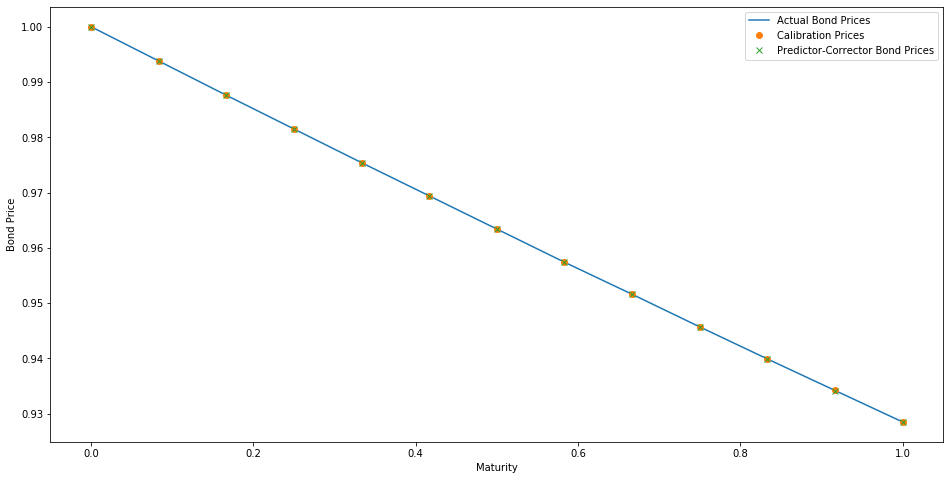

In [4]:
# define numbers of simulations
n = 100000

# initialize predictor-corrector Monte Carlo simulation forward rate
predcorr_forward = np.ones([n, opt.N])*(opt.model_prices[:-1]-opt.model_prices[1:])/(opt.delta_t*opt.model_prices[1:])
predcorr_capfac = np.ones([n, opt.N+1])
delta = np.ones([n, opt.N])*opt.delta_t

# calculate the forward rate for each steps from the bond price
for i in range(1, opt.N):
    # generate random numbers follow normal distribution
    Z = opt.sigma*sqrt(delta[:,i:])*norm.rvs(size = [n,1])

    # predictor-corrector Monte Carlo simulation
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*opt.sigma**2/(1+delta[:,i:]*predcorr_forward[:,i:]), axis = 1)
    temp = predcorr_forward[:,i:]*exp((mu_initial-opt.sigma**2/2)*delta[:,i:]+Z)
    mu_term = np.cumsum(delta[:,i:]*temp*opt.sigma**2/(1+delta[:,i:]*temp), axis = 1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*exp((mu_initial + mu_term - opt.sigma**2)*delta[:,i:]/2+Z)

# implying capitalization factors from the forward rates
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward,axis = 1)

# inverting the capitalization factors to imply bond prices (discount factors)
predcorr_price = predcorr_capfac**(-1)

# taking averages: Forward Rate, Bond Price, Capitalization Factors
# mean Forward Rate
opt.forward_rate = np.mean(predcorr_forward,axis = 0)

# mean Price 
predcorr_price = np.mean(predcorr_price,axis = 0)

# mean Capitalization Factors
opt.capfac = np.mean(predcorr_capfac,axis = 0)

# plot results
plt.subplots(figsize=(16, 8))
plt.xlabel('Maturity')
plt.ylabel('Bond Price')
plt.plot(maturity, zcb_prices, label = 'Actual Bond Prices')
plt.plot(maturity, opt.model_prices, 'o', label = 'Calibration Prices')
plt.plot(maturity, predcorr_price,'x',label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

# Simulation

Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. You should simulate the values monthly and should have LIBOR forward rates applying over one month, starting one month apart, up to maturity. You may assume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates.

We perform Monte Carlo simulations based on the parameters already established. In this case, we simulate and estimate local volatility and stock paths, and counterparty firm values. Also, we estimate the payoff and losses, the call price and the CVA. 

In [4]:
def simulate(Option, n = 10000, gamma = 0.75): 
    Option.stock_paths = []      # stock simulation paths
    Option.firm_paths = []       # firm simulation paths
    Option.payoffs = []          # call payoffs
    Option.losses = []           # firm amount of loss
    
    # Constans calculate outside the loop for optimization
    corr_matrix = np.linalg.cholesky(np.array([[1,Option.c],[Option.c,1]]))
 
    for i in range(n):
        stock_path = []
        firm_path = [] 
        S_j = Option.S
        Sf_j = Option.Sf
        for j in range(Option.N):
            stock_path.append(S_j)
            firm_path.append(Sf_j)
            xi = np.matmul(corr_matrix, norm.rvs(size = 2))

            # local volatilities
            v_dt = Option.v*(S_j)**(gamma-1)
            vf_dt = Option.vf*(Sf_j)**(gamma-1)
            
            # continuously compounded interest rate
            Option.r = log(1 + opt.forward_rate[j]*Option.delta_t)/Option.delta_t
            
            # stock price
            S_j *= exp((Option.r-1/2*(v_dt**2))*Option.delta_t + 
                       v_dt*sqrt(Option.delta_t)*xi[0]) 
            
            # firm price
            Sf_j *= exp((Option.r-1/2*(vf_dt**2))*Option.delta_t + 
                       vf_dt*sqrt(Option.delta_t)*xi[1])   
            
        # Saving the stock and firm path
        Option.stock_paths.append(stock_path)
        Option.firm_paths.append(firm_path)

        # Call payoff
        if np.max(stock_path) < Option.B:
            Option.payoffs.append(np.maximum(stock_path[-1] - Option.K,0))
        else:
            Option.payoffs.append(0)

        # Firm's losses
        if np.min(firm_path) < Option.D:
            Option.losses.append(exp(-Option.vf*Option.T)*(1-Option.rr)*Option.payoffs[-1])
        else:
            Option.losses.append(0)

    # uses payoff vector and discount factor to compute the price of the option 
    Vi = exp(-Option.r * Option.T) * np.array(Option.payoffs, dtype=float)
    Option.call = np.mean(Vi)
    Option.call_sd = np.std(Vi) / np.sqrt(n*Option.N)

    # estimating CVA
    Option.cva = np.mean(Option.losses)
    Option.cva_sd = np.std(Option.losses) / np.sqrt(n*Option.N)
        
# run simulation
simulate(opt, n)
print("Done...")

Done...


In order to show our results, we shall generate some plots. The following plot shows the resulting simulated paths of the stock price.

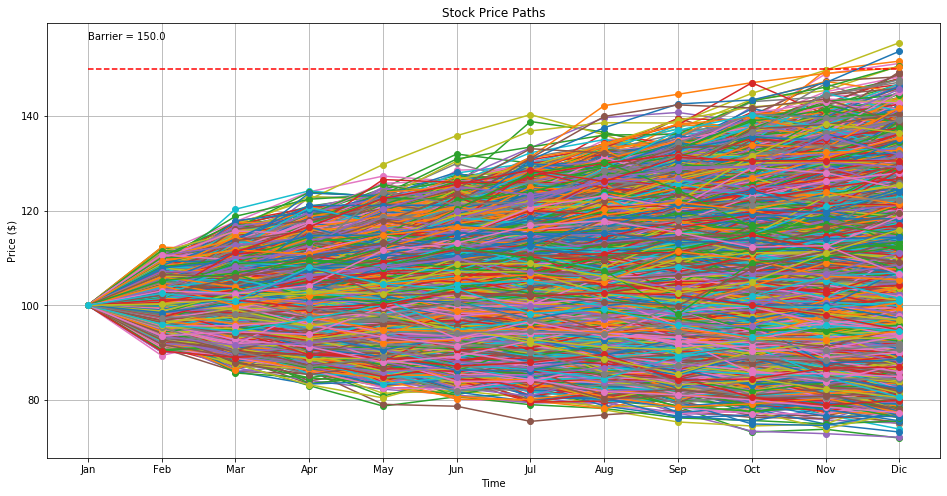

In [5]:
"""Plot stock simulations"""
dates = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dic"]
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(opt.stock_paths, columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.plot([opt.B]*len(dates), linestyle='--', color ='r')
plt.figtext(0.16,0.85,'Barrier = '+ str(opt.B))
plt.title('Stock Price Paths')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

Now, let's plot the firm's paths.

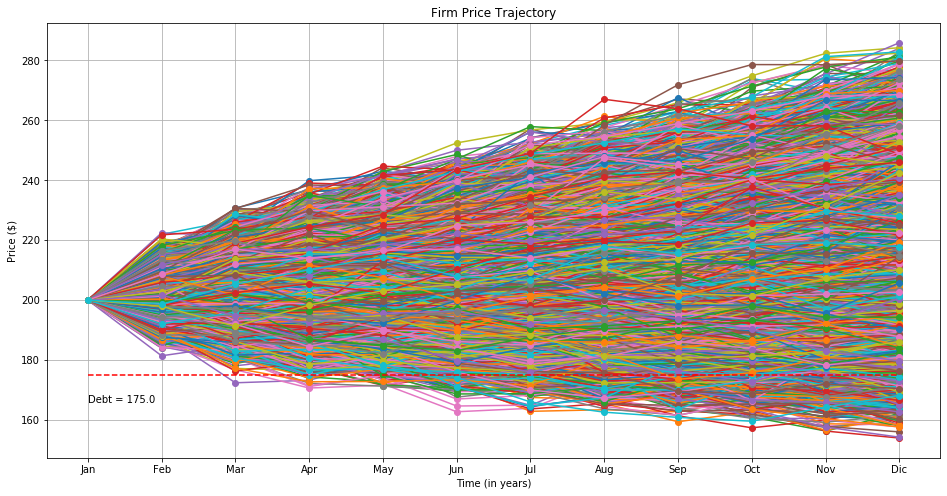

In [6]:
"""Plot firm simulations"""
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(opt.firm_paths, columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.plot([opt.D]*len(dates), linestyle='--', color ='r')
plt.figtext(0.16,0.22,'Debt = '+ str(opt.D))
plt.title('Firm Price Trajectory')
plt.xlabel('Time (in years)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show() 

The results show how certain paths crossed over the barrier and debt values. From these graphs, we gain an understanding of stock prices and firm values at a certain time before maturity. However, we also want to simulate the stock price and firm value changes as the time to maturity changes. Therefore, we record the stock price/firm value each month until maturity. Each month, we use a different sample size to evaluate the price paths. The paths are shown above.

The stock price paths and firm value paths are plotted above. We observed a similar pattern where the variance increases over time. The stock price at maturity ranging from \\$70 to \\$170, the firm value at maturity ranging from \\$160 to \\$280.

# Pricing

Calculate the one-year discount factor which applies for each simulation and use this to find first the value of the option for the jointly simulated stock and firm paths with no default risk, and then the value of the option with counterparty default risk.

The timestep is calculated annually instead of monthly as in the previous question. We jointly simulate the firm value and the stock price in the next year with CVA considered. The option prices for two scenarios (without default risk and with default risk) are calculated. We output some results already obtained in the simulation. 

In [7]:
# print the results
print('Call price = ', opt.call)
print('Call price sd = ', opt.call_sd)
print('CVA = ', opt.cva)
print('CVA sd = ', opt.cva_sd)
print('Call - CVA = ', opt.call-opt.cva)

Call price =  7.680551857504103
Call price sd =  0.006757328062637765
CVA =  0.02459770122120437
CVA sd =  0.0003815136381486519
Call - CVA =  7.655954156282898


The option price adjusted for CVA is a little lower, as we would expect, due to the additional risk of credit default by the counterparty firm that in this case, is not high. After 100,000 simulations, the estimated call price (no default) is 7.66, the estimated call price (counterparty risk included) is 7.63. Next, we perform a CVA-correlation analysis to see how it performs.  

Default Probability =  0.29461742385693723
Uncorrelate CVA =  3.4716198212035505


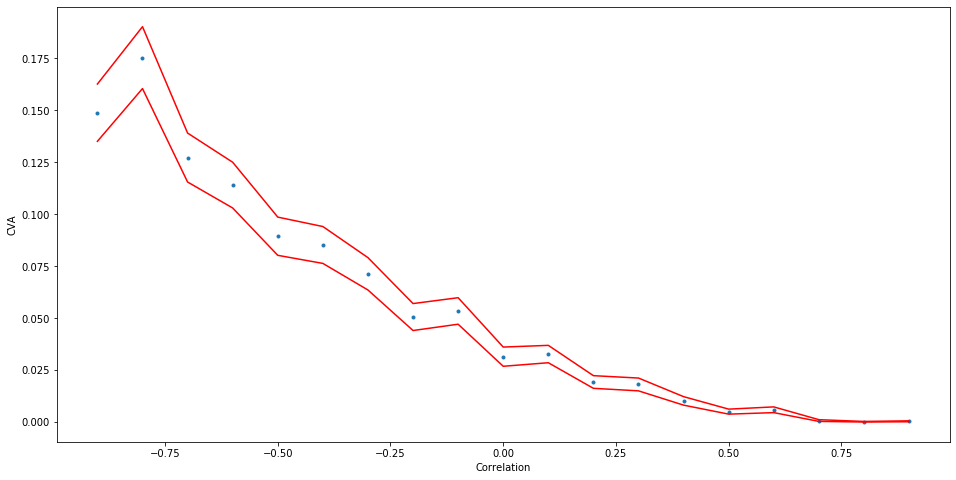

In [8]:
# inizilising values and simulations
corr = np.linspace(-0.9, 0.9, 19)
cvacorr = []              # cva mean in each simulation
cvacorr_sd = []           # cva sd in each simulation
for i in corr:
    opt.c = i 
    simulate(opt,10000)
    cvacorr.append(opt.cva)
    cvacorr_sd.append(opt.cva_sd)

# code to calculate default probability
d1 = (log(opt.Sf/opt.D) + (opt.r + opt.vf**2 / 2.)*opt.T) / (opt.vf * sqrt(opt.T))
d2 = d1 - opt.vf * sqrt(opt.T)
default_prob = stats.norm.cdf(-d2)
uncorr_cva = (1 - opt.rr) * default_prob * opt.analytic_price
print("Default Probability = ",default_prob)
print("Uncorrelate CVA = ",uncorr_cva)
plt.subplots(figsize=(16, 8))
plt.plot(corr, cvacorr, '.')
plt.plot(corr, cvacorr + 3 * np.array(cvacorr_sd), 'r')
plt.plot(corr, cvacorr - 3 * np.array(cvacorr_sd), 'r')
plt.xlabel('Correlation')
plt.ylabel('CVA')
plt.show()

As can be seen in this figure, as the correlation gets smaller, our CVA gets a little larger. This is because as our stock performs well, the value of our call option grows, but the firm is more likely to perform poorly. This negative correlation results in wrong way risk.

# Conclusion

We have investigated a particular European up-and-out call option, using Monte Carlo simulations to determine the progression of the stock price and the counterparty firm's value at monthly intervals over a 12-month period. We can see from the output of the plots entitled  "Stock Price Trajectory" and "Firm Price Trajectory" that both the share price and the firm value become more stable as the sample size increases. From these graphs, we gain an understanding of stock prices and firm values at a certain time before maturity. In general, both stock and firm values increase over time as the time to maturity decreases. It can further be observed that the stock price and firm values have positive correlation.

We then estimate option price values using increasing 100,000 simulations for the default-free value of the option (vanilla Black-Scholes). The option price obtained was at around \\$ 7.66. 

Finally, we estimated the adjusted value of the option which is the default-free price less the CVA. This clearly shows a lower value for the option price which is to be expected as we are taking on some additional risk that the counterparty firm may indeed default on their obligation, leading us to experience some loss on our investment.

Exotic options are a category of options contracts that differ from traditional options in their payment structures, expiration dates, and strike prices. Exotic options are simply more complicated and complex than vanilla options. They have secondary characteristics, such as callability and putability, that can change their role in a derivatives portfolio. 

# References

Hayes, A. 2019. “*Vasicek Interest Rate Model Definition.*”

Hull, John C. 2006. “*Options, Futures, and Other Derivatives.*” Upper Saddle River, NJ: Pearson Prentice Hall.

Hunter, C. J., Jäckel, P. and Joshi, M. S. (2001). “*Drift Approximations in a Forward-Rate-Based LIBOR Market Model*”, Getting the Drift, pp. 81–84.

Mamon, R. S. (2004). “*Three Ways to Solve for Bond Prices in the Vasicek Model*”. Advances in Decision Sciences, 8(1), pp. 1–14.

Yuxing Yan. 2017. "*Python for Finance - Second Edition*", PackT. https://www.packtpub.com/big-data-and-business-intelligence/python-finance-second-edition#tab-label-product.info.authors.tab

# Appendix

We implemented another algorithm for price simulation; in this case, all simulations occur jointly and simultaneously. We present it here as a plus for our research but it's not a 100\% verified algorithm. 

In [5]:
def simulate2(Option, n = 10000, gamma = 0.75):   
    Option.stock = []            # stock mean in each simulation
    Option.stock_sd = []         # stock sd in each simulation
    Option.firm = []             # firm mean in each simulation
    Option.firm_sd = []          # firm sd in each simulation
    Option.stock_prices = []
    Option.firm_prices = []
    Option.bond_prices = []
    stock_price = [Option.S] * n     
    firm_price = [Option.Sf] * n   
    predcorr_capfac = 1 
    
    # Constans calculate outside the loop for optimization
    corr_matrix = np.linalg.cholesky(np.array([[1,Option.c],[Option.c,1]]))
    

    for i in range(Option.N):
        # Saving the stock and firm path
        Option.stock_prices.append(stock_price[:])
        Option.firm_prices.append(firm_price[:])     
        predcorr_forward = (Option.model_prices[i] - Option.model_prices[i+1]) / (Option.delta_t*Option.model_prices[i+1])
        mu_1 = 0
        mu_2 = 0
        for j in range(n):
            xi = np.matmul(corr_matrix, norm.rvs(size = 2))

            # local volatilities
            v_dt = Option.v*(stock_price[j])**(gamma-1)
            vf_dt = Option.vf*(firm_price[j])**(gamma-1)

            # continuously compounded interest rate
            Option.r = log(1+Option.delta_t*predcorr_forward)/Option.delta_t
            
            # stock price
            stock_price[j] *= exp((Option.r-1/2*(v_dt**2))*Option.delta_t + 
                                  v_dt*sqrt(Option.delta_t)*xi[0])
            # firm price
            firm_price[j] *= exp((Option.r-1/2*(vf_dt**2))*Option.delta_t + 
                              vf_dt*sqrt(Option.delta_t)*xi[1])
         
            # Predictor-Corrector Monte Carlo Simulation
            Z = opt.sigma*sqrt(Option.delta_t)*norm.rvs()
            mu_1 += Option.delta_t*predcorr_forward*Option.sigma**2/(1+Option.delta_t*predcorr_forward)
            temp = predcorr_forward*exp((mu_1 - Option.sigma**2/2)*Option.delta_t*Z)
            mu_2 += Option.delta_t*temp*Option.sigma**2/(1+Option.delta_t*temp)
            new_predcorr_forward = predcorr_forward*exp((mu_1 + mu_2 - Option.sigma**2)*Option.delta_t*0.5 + Z)
        
        # implying capitalization factors from the forward rates
        predcorr_capfac *= 1+Option.delta_t*new_predcorr_forward
        
        # inverting the capitalization factors to imply bond prices (discount factors)
        Option.bond_prices.append(predcorr_capfac**(-1)) 
        
        # stock mean and sd in each simulation
        Option.stock.append(np.mean(stock_price))
        Option.stock_sd.append(np.std(stock_price) / np.sqrt(n*Option.N))

        # firm mean and sd in each simulation
        Option.firm.append(np.mean(firm_price))
        Option.firm_sd.append(np.std(firm_price) / np.sqrt(n*Option.N))
        # print(int((i+1)*100./Option.N),"%... ", end ='')
    
# run simulation
simulate2(opt)
print("Done...")

Done...


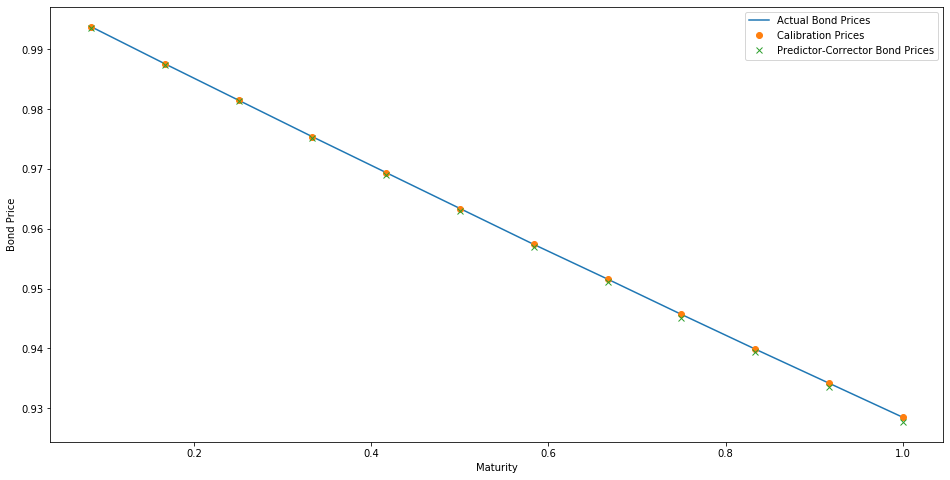

In [6]:
# plot results
plt.subplots(figsize=(16, 8))
plt.xlabel('Maturity')
plt.ylabel('Bond Price')
plt.plot(maturity[1:], zcb_prices[1:], label = 'Actual Bond Prices')
plt.plot(maturity[1:], opt.model_prices[1:], 'o', label = 'Calibration Prices')
plt.plot(maturity[1:], opt.bond_prices,'x',label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

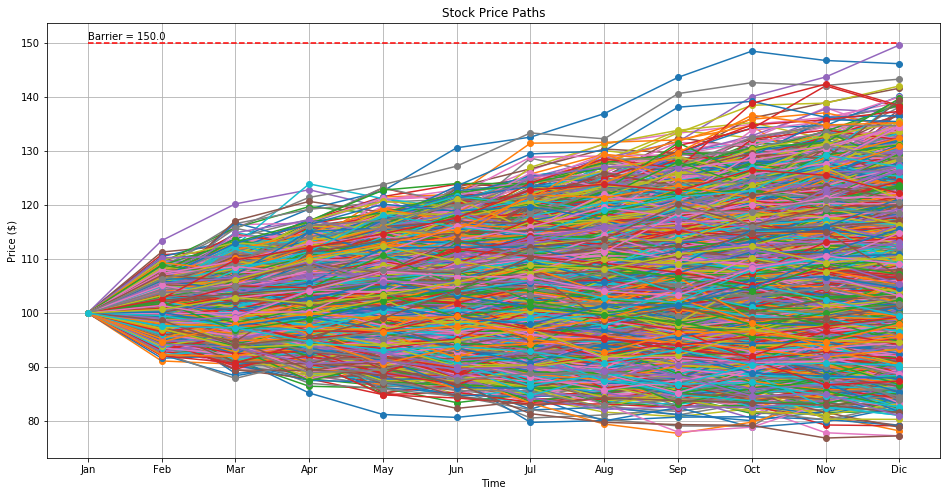

In [8]:
"""Plot stock simulations"""
dates = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dic"]
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(np.transpose(opt.stock_prices), columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')
    
plt.plot([opt.B]*len(dates), linestyle='--', color ='r')
plt.figtext(0.16,0.85,'Barrier = '+ str(opt.B))
plt.title('Stock Price Paths')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

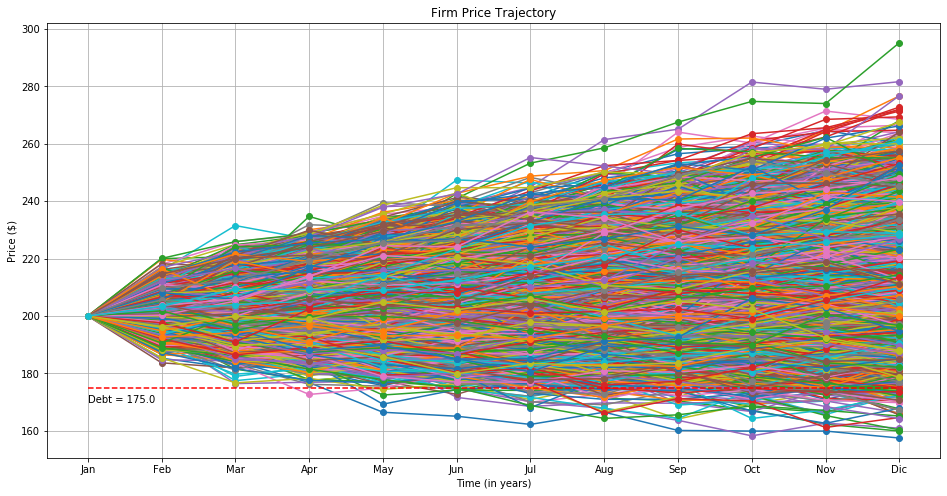

In [9]:
"""Plot firm simulations"""
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(np.transpose(opt.firm_prices), columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.plot([opt.D]*len(dates), linestyle='--', color ='r')
plt.figtext(0.16,0.22,'Debt = '+ str(opt.D))
plt.title('Firm Price Trajectory')
plt.xlabel('Time (in years)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show() 

The results obtained are almost identical to the no-joint simulations algorithm, but with an improvement in computational efficiency.